C:\Users\matte\AppData\Local\Temp\ipykernel_91308\1947923985.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Errore assoluto medio (MAE): 2.5891117655883806


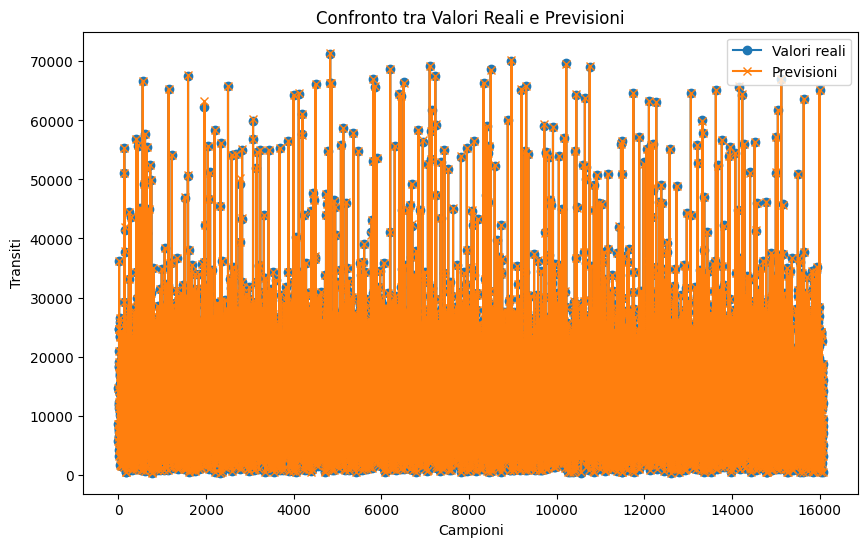

In [6]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# ============================
# 1. Caricamento dei dati
# ============================
host = "localhost"
port = "5432"
dbname = "DataScience"
user = "postgres"
password = "2430"

conn = psycopg2.connect(host=host, port=port, dbname=dbname, user=user, password=password)
query = """
SELECT postazione, giorno, ngiornosettimana, strada, transiti, trnonclassificato, trleggeri, 
       trpesanti, trdiurno, trnotturno, trferiali, trfestivi, sensori, provincia, comune, 
       tipo_strada, numero_strada, nome_strada
FROM public.mts_anagrafica;
"""
df = pd.read_sql_query(query, conn)
conn.close()

# ============================
# 2. Calcolare le correlazioni
# ============================
strade = df['strada'].unique()
traffic_data = df.pivot_table(index='giorno', columns='strada', values='transiti', aggfunc='sum')
corr_matrix = traffic_data.corr()

# ============================
# 3. Trovare la strada con la massima correlazione per ogni strada
# ============================
correlazioni_massime = {}
for strada in strade:
    corr_values = corr_matrix[strada].drop(strada)
    correlazioni_massime[strada] = corr_values.idxmax()

# ============================
# 4. Unire i dati della strada correlata
# ============================
df['strada_correlata'] = df['strada'].map(correlazioni_massime)
df_correlata = df[['giorno', 'strada', 'transiti']].copy()
df_correlata = df_correlata.rename(columns={'strada': 'strada_merge', 'transiti': 'transiti_correlata'})
df_merged = df.merge(df_correlata,
                     left_on=['giorno', 'strada_correlata'],
                     right_on=['giorno', 'strada_merge'],
                     how='left')

# ============================
# 5. Previsione con il modello migliorato
# ============================
# Selezioniamo un insieme più ridotto di feature
features = ['transiti_correlata', 'ngiornosettimana', 'trleggeri', 'trpesanti', 'trferiali', 'trfestivi']
X = df_merged[features]
y = df_merged['transiti']  # No log transformation

# Suddividiamo il dataset in training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizziamo le feature
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creiamo il modello con parametri di base
model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42)
model.fit(X_train_scaled, y_train)

# Effettuiamo le previsioni
y_pred = model.predict(X_test_scaled)

# Calcoliamo l'errore assoluto medio (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Errore assoluto medio (MAE): {mae}")

# Visualizziamo il confronto tra valori reali e previsioni
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Valori reali', marker='o')
plt.plot(y_pred, label='Previsioni', marker='x')
plt.xlabel('Campioni')
plt.ylabel('Transiti')
plt.title('Confronto tra Valori Reali e Previsioni')
plt.legend()
plt.show()
